<a href="https://colab.research.google.com/github/CS20M038/CS6910-assignment_3/blob/main/DL_Assignment_3_Arjun_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import all the libraries that would be used in this notebook
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import LSTM,Dense
import csv
import os
from keras.utils.vis_utils import plot_model

In [ ]:
# to mount to the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#make sure to upload the Dakshina Dataset in your drive and name the folder as Dakshina_Dataset
dakshina_dataset_hindi = '/content/drive/MyDrive/Dakshina_Dataset/hi/lexicons'

In [ ]:
dev_dataset_path = os.path.join(dakshina_dataset_hindi,"hi.translit.sampled.dev.tsv")
train_dataset_path = os.path.join(dakshina_dataset_hindi,"hi.translit.sampled.train.tsv")
test_dataset_path = os.path.join(dakshina_dataset_hindi,"hi.translit.sampled.test.tsv")

In [ ]:
def load_dataset(path):
    dataset = open(path)
    read_dataset = csv.reader(dataset,delimiter = '\t')
    x = []
    y = []
    for row in read_dataset:
        x.append(row[1])
        y.append("\t"+row[0]+'\n')

    return np.array(x),np.array(y)


In [ ]:
x_raw_train,y_raw_train = load_dataset(dev_dataset_path)

In [ ]:
english_alphabets = 'abcdefghijklmnopqrstuvwxyz'
english_alpha2index = {"PAD": 0}
for index,alpha in enumerate(english_alphabets):
    english_alpha2index[alpha] = index + 1

hindi_alphabets = [chr(alpha) for alpha in range(2304, 2432)]
hindi_alphabets.append('\t')
hindi_alphabets.append('\n')
hindi_alpha2index = {"PAD" : 0}
for index,alpha in enumerate(hindi_alphabets):
    hindi_alpha2index[alpha] = index + 1

english_index2alpha = {0: "PAD"}
hindi_index2alpha = {0: "PAD"}

for index,alpha in enumerate(english_alphabets):
    english_index2alpha[alpha] = index + 1

for index,alpha in enumerate(hindi_alphabets):
    hindi_index2alpha[alpha] = index + 1



In [ ]:
def get_integer_encode(word,alpha2index,max_length = 25):
    integer_encode = np.zeros((max_length,),dtype='int')
    for index,alpha in enumerate(word):
        integer_encode[index] = alpha2index[alpha]
    return integer_encode

def encode_docs(docs,alpha2index,max_length = 25):
    encoded_docs = np.zeros((docs.shape[0],max_length),dtype='int')
    for index,word in enumerate(docs):
        encoded_docs[index] = get_integer_encode(word,alpha2index)
    return encoded_docs



In [ ]:
integer_encoded_x_train = encode_docs(x_raw_train,english_alpha2index)
integer_encoded_y_train = encode_docs(y_raw_train,hindi_alpha2index)

In [ ]:
decoder_input_data = np.zeros((integer_encoded_y_train.shape[0],25,len(hindi_alpha2index)),dtype="float32")
decoder_output_data = np.zeros((integer_encoded_y_train.shape[0],25,len(hindi_alpha2index)),dtype="float32")

for i,integer_encoded_data in enumerate(integer_encoded_y_train):
    for t,integer in enumerate(integer_encoded_data):
        decoder_input_data[i, t, integer]= 1.0
        if t > 0:
            decoder_output_data[i, t - 1, integer] = 1.0

In [ ]:
batch_size = 64  
epochs = 5 
latent_dim = 256

In [ ]:
embedding_inputs = keras.Input(shape=(25))
embedding_layer = Embedding(len(english_alpha2index), 125 , input_length=25)
encoder_inputs = embedding_layer(embedding_inputs)
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, len(hindi_alpha2index)))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(len(hindi_alpha2index), activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([embedding_inputs, decoder_inputs], decoder_outputs)

In [ ]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [integer_encoded_x_train, decoder_input_data],
    decoder_output_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
)

Epoch 1/5
62/62 [==============================] - 22s 295ms/step - loss: 1.6880 - accuracy: 0.7245 - val_loss: 1.2290 - val_accuracy: 0.7333
Epoch 2/5
62/62 [==============================] - 17s 277ms/step - loss: 1.0508 - accuracy: 0.7470 - val_loss: 1.0611 - val_accuracy: 0.7461
Epoch 3/5
62/62 [==============================] - 17s 277ms/step - loss: 0.9967 - accuracy: 0.7560 - val_loss: 1.0041 - val_accuracy: 0.7639
Epoch 4/5
62/62 [==============================] - 17s 279ms/step - loss: 0.9248 - accuracy: 0.7698 - val_loss: 0.9679 - val_accuracy: 0.7670
Epoch 5/5
62/62 [==============================] - 17s 279ms/step - loss: 0.8809 - accuracy: 0.7788 - val_loss: 0.9498 - val_accuracy: 0.7711


In [ ]:
model.save("s2s")

INFO:tensorflow:Assets written to: s2s/assets


INFO:tensorflow:Assets written to: s2s/assets


In [ ]:
model = keras.models.load_model("s2s")

(None, 25, 125)
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 25, 125)           3375      
_________________________________________________________________
lstm (LSTM)                  [(None, 256), (None, 256) 391168    
Total params: 394,543
Trainable params: 394,543
Non-trainable params: 0
_________________________________________________________________
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 131)]  0                                            
_____________________________________________________

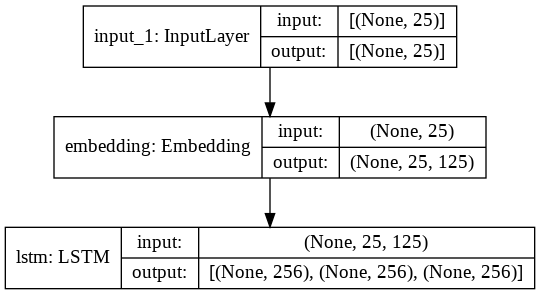

In [ ]:
#model.summary()

embedding_inputs = model.input[0]  # input_1
embedding_l1 = model.layers[1]
encoder_inputs = embedding_l1(embedding_inputs)
print(encoder_inputs.shape)
encoder_lstm = model.layers[3]
encoder_outputs, state_h_enc, state_c_enc = encoder_lstm(encoder_inputs)
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(embedding_inputs, encoder_states)
encoder_model.summary()

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,), name="input_3")
decoder_state_input_c = keras.Input(shape=(latent_dim,), name="input_4")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[4]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[5]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)
decoder_model.summary()
plot_model(encoder_model, to_file='decoder_model.png', show_shapes=True)

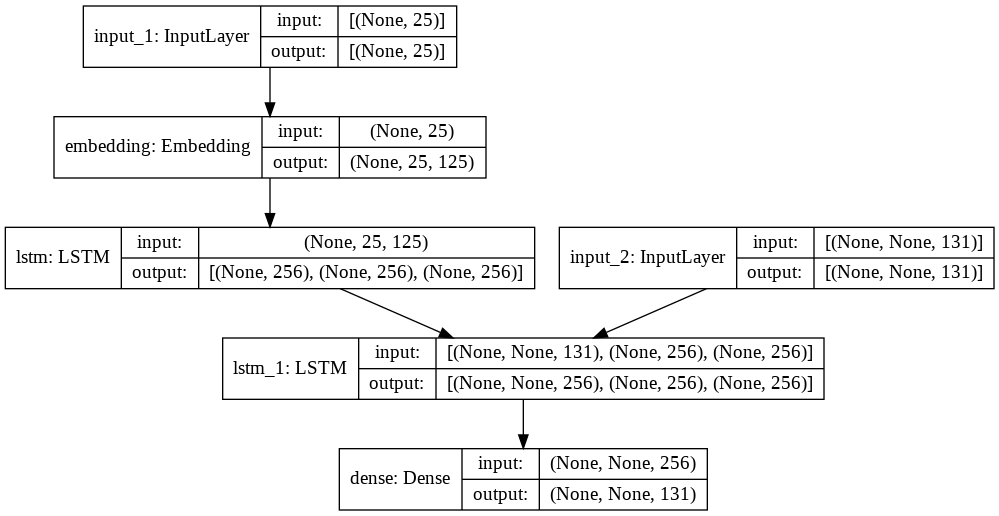

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
def decode_sequence(word):
    input_seq = get_integer_encode(word,english_alpha2index)
    
    states_value = encoder_model.predict(input_seq)
    print(np.array(states_value).shape)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros(( 1, len(hindi_alpha2index)))
    # Populate the first character of target sequence with the start character.
    target_seq[0, hindi_alpha2index["\t"]] = 1.0
    print(target_seq)

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_word = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = hindi_index2alpha[sampled_token_index]
        decoded_word += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_word) > 25:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_word

In [ ]:
def decode_sequence1(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    print(np.array(states_value).shape)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 131))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, 0] = 1 
    # START (0 zero) in one-hot-encoding --> [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_seq = list()
    while not stop_condition:

        # in a loop
        # decode the input to a token/output prediction + required states for context vector
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # convert the token/output prediction to a token/output
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = sampled_token_index
        # add the predicted token/output to output sequence
        decoded_seq.append(sampled_char)
        

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == 0 or
           len(decoded_seq) == max_output_sequence):
            stop_condition = True

        # Update the input target sequence (of length 1) 
        # with the predicted token/output 
        target_seq = np.zeros((1, 1, output_dimension))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update input states (context vector) 
        # with the ouputed states
        states_value = [h, c]

        # loop back.....
        
    # when loop exists return the output sequence
    return decoded_seq

In [ ]:
print(decode_sequence1(get_integer_encode("arjun",english_alpha2index)))
# input_seq = get_integer_encode("arjun",english_alpha2index)
# print(input_seq)

ValueError: ignored